# Forecasting Stock prices

In [25]:
# Importing libraries for analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

# Importing libraries for forecasting
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error

# Removing all the warnings
import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

We don't need to do data clean as I already checked the data is clean.  
One thing I want to point out that the data for weekends is missing in the stocks prices due to holiday. We we don't need to worry the models we will use can handle missing values


In [26]:
# Importing '^BSESM' stock prices from yahoo finanace
data = yf.download("^BSESN", start="2001-01-01", end="2022-04-01")
# Getting only the close prices
close_price = data['Close'].to_frame()
# Making index a column
close_price = close_price.reset_index()
# Renaming the columns(prophet model takes date column as 'ds' and target column as 'y')
close_price = close_price.rename(columns={'Date':'ds','Close':'y'})
close_price.shape

[*********************100%%**********************]  1 of 1 completed


(5235, 2)

In [27]:
close_price.head()

,ds,y
0,2001-01-02,4018.879883
1,2001-01-03,4060.020020
2,2001-01-04,4115.370117
3,2001-01-05,4183.729980
4,2001-01-08,4120.430176


The stocks data is from **2001-01-01** to **2022-04-01**   


---



We also have the news data for the same period. I already cleaned and preprocessed the news data. I extracted the sentiments of the news that we will use in our model. Then I stored the preprocessed news data into my drive.  
I did this because every time the session crashed for any reason the data reset and have to run all the preprocessing code again which almost took 30 minutes

`You can find it in this drive link` : [news_preprocessed_data](https://drive.google.com/file/d/1LFT5H9cczgIpVYTMlMqywjKi0vwBm2Ym/view?usp=sharing)


In [28]:
# Importing from the drive
news_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessed_news_data')

In [29]:
# Creating a new data frame that only contains the dates and sentiments and renaming the sentiment column to holiday
# (as prophet model only accepts the column named holiday as exogeneous regressor)
news_sentiments = news_df[['ds','Sentiment']].rename(columns={'Sentiment':'holiday'})
# Grouping the dataframe on the bases of dates to make it of the same shape as the stock price column(daily frequency)
news_sentiments = news_sentiments.groupby('ds')['holiday'].mean().to_frame()
# Reseting the index
news_sentiments = news_sentiments.reset_index()
# Converting the date column to datetime
news_sentiments['ds'] = pd.to_datetime(news_sentiments['ds'])

news_sentiments.shape

(7717, 2)

As we can see that our news data has more rows than stocks data. This is because stock market is closed in certain holidays.   
So we will merge them in way that only the dates that are present in the stocks data are retained in the news data

In [30]:
news_sentiments.head()

,ds,holiday
0,2001-01-02,0.042829
1,2001-01-03,0.011280
2,2001-01-04,0.038048
3,2001-01-05,0.141441
4,2001-01-06,0.128030


<Axes: xlabel='ds', ylabel='holiday'>

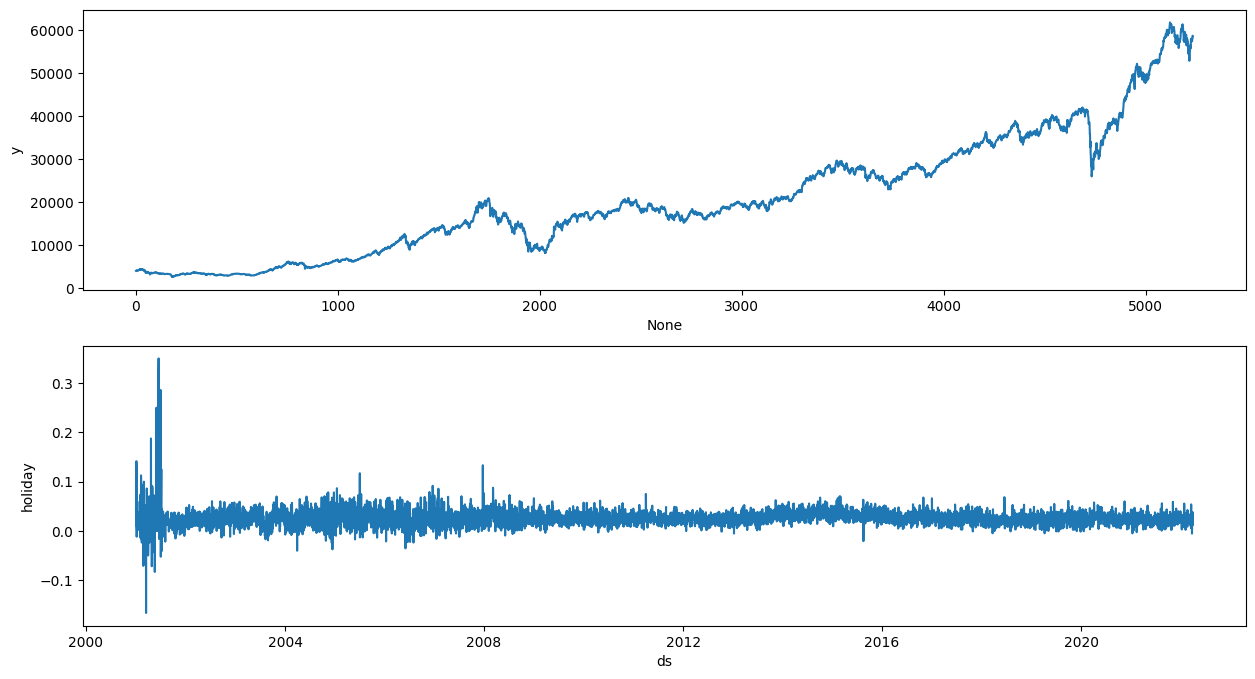

In [31]:
# Examining the data by plotting it
fig, ax = plt.subplots(2,1, figsize=(15,8))
sns.lineplot(data=close_price, x=close_price.index, y='y', ax=ax[0])
sns.lineplot(data=news_sentiments, x='ds', y='holiday', ax=ax[1])

The data looks ok

In [32]:
# Doing adfuller test for stationarity
adf_result = adfuller(close_price['y'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: 1.0560093592098885
p-value: 0.9948231279538028


Results suggest that our data is not stationary but don't worry the model we are using deal with that

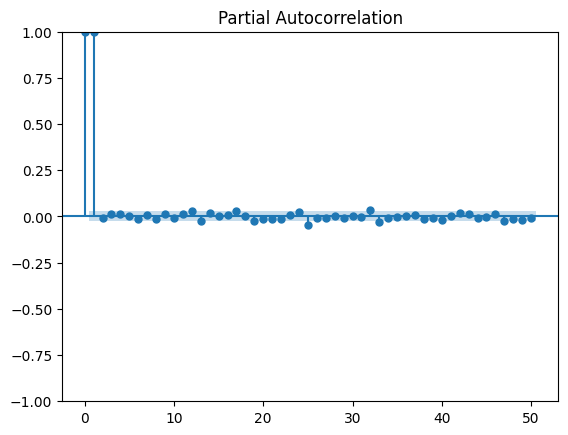

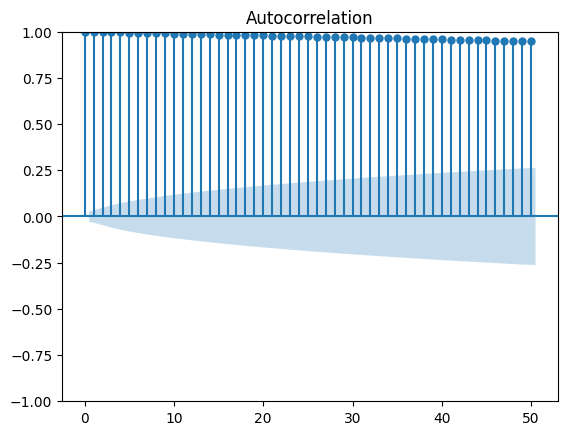

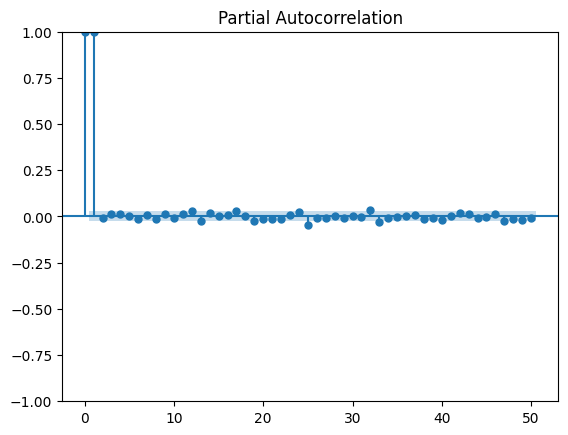

In [33]:
# Lets plot hte acf and pach plot to find the values of 'p' and 'q' for our ARIMA model
plot_acf(close_price['y'], lags=50)
plot_pacf(close_price['y'], lags=50)

ACF plot shows that our data has a trend(as its slowly moving down).   
PACF plot shows that there is a correlation between the first lag values only

In [34]:
# Merging both dataset on the 'ds' column. Doing a left join
full_df = pd.merge(close_price, news_sentiments, on='ds', how='left')
# There were some missing values generated in dolidays column. So will drop them(I tried imputation but it got even worse)
full_df = full_df.dropna()
full_df.shape

(5206, 3)

In [35]:
full_df.head()

,ds,y,holiday
0,2001-01-02,4018.879883,0.042829
1,2001-01-03,4060.020020,0.011280
2,2001-01-04,4115.370117,0.038048
3,2001-01-05,4183.729980,0.141441
4,2001-01-08,4120.430176,0.010363


We will use time series split from sklearn as our data is sequential

In [36]:
# Splitting our data for training and testing using TimeSeriesSplit form sklearn
tscv = TimeSeriesSplit(n_splits=5, gap=0)

# Split the data into training and testing sets
for train_index, test_index in tscv.split(full_df):
    train = full_df.iloc[train_index]
    test = full_df.iloc[test_index]

# Print the shapes of the training and testing sets
print("Train stock prices data shape:", train.shape)
print("Test stock prices data shape:", test.shape)

Train stock prices data shape: (4339, 3)
Test stock prices data shape: (867, 3)


In [37]:
train.shape, test.shape

((4339, 3), (867, 3))

## prophet model for forecasting


In [38]:
# Creating a Prophet model with parameters
model = Prophet(
    # Seasonality Settings
    yearly_seasonality=10,       # Number of Fourier terms for yearly seasonality
    weekly_seasonality=5,        # Number of Fourier terms for weekly seasonality
    daily_seasonality=True,     # Stock markets are typically not open daily but it improved the model's prediction

    # Trend Flexibility
    changepoint_prior_scale=0.1, # Higher values allow for more trend changes

    # Handling Outliers (important for stock price spikes)
    seasonality_mode='multiplicative', # Often better for stock prices than 'additive'
)

# Incorporate additional regressors (optional)
# These are external factors that could affect stock prices
# We will use our news_sentiment dataset
model.add_regressor('holiday')

# Country-specific holidays(as the stocks are of india so we will use india's holidays)
model.add_country_holidays(country_name='IND')

# Fit the model on the training data
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmptx4zjkor/zu6jgrnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptx4zjkor/_8kku35s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96036', 'data', 'file=/tmp/tmptx4zjkor/zu6jgrnb.json', 'init=/tmp/tmptx4zjkor/_8kku35s.json', 'output', 'file=/tmp/tmptx4zjkor/prophet_modelnk0yaec4/prophet_model-20240617080307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:03:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:03:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
# Taking prediction on the future dates
forecast = model.predict(test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Day of Ashura (estimated),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2018-09-18,5076.367220,33534.849773,36375.856171,5076.367220,5076.367220,0.0,0.0,0.0,0.0,...,0.334550,0.334550,0.334550,0.050171,0.050171,0.050171,0.0,0.0,0.0,35022.521968
1,2018-09-19,5077.514974,33446.538495,36429.153744,5077.514974,5077.514974,0.0,0.0,0.0,0.0,...,0.338365,0.338365,0.338365,0.044968,0.044968,0.044968,0.0,0.0,0.0,34990.671512
2,2018-09-21,5079.810483,33593.299880,36449.242483,5079.810483,5079.810483,0.0,0.0,0.0,0.0,...,0.337427,0.337427,0.337427,0.033470,0.033470,0.033470,0.0,0.0,0.0,35085.166941
3,2018-09-24,5083.253746,33634.694885,36465.370502,5083.253746,5083.253746,0.0,0.0,0.0,0.0,...,0.328977,0.328977,0.328977,0.015520,0.015520,0.015520,0.0,0.0,0.0,35030.071577
4,2018-09-25,5084.401500,33506.089714,36400.743403,5084.401500,5084.401500,0.0,0.0,0.0,0.0,...,0.334550,0.334550,0.334550,0.009909,0.009909,0.009909,0.0,0.0,0.0,34938.218491


In [40]:
# Lets plot the predicion
plot_plotly(model, forecast)

They seem like very well

In [41]:
# Here we will plot the components the comtibute in prediction
plot_components_plotly(model, forecast)

In [42]:
# Getting the mean absoute error
mae = mean_absolute_error(forecast['yhat'], test['y'])
print(mae)

5676.907462859071



Without any indicator: 5734.558685314083   
With india's holidays indicators: 5729.916291300043  
With india's holidays indicators and news sentiments: 5714.767339587773   
After some more tunning : 5676.907462859071

We can see that indicator actually improved our predictions. After all it is stock prices and If it was so easy everyone would be a billionare😂😂

Until next time   
Allah Hafiz